NOTE: defining the HOME path constant

In [2]:
import os
HOME = os.getcwd()
print(f'HOME directory path: \'{HOME}\'')

HOME directory path: '/content'


### Important ! Add "requirements.txt" file to working directory

In [3]:
# Installing required packages
!pip install -r {HOME}/requirements.txt --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 902.2/902.2 kB 52.1 MB/s eta 0:00:00


### Connecting to Roboflow dataset

In [4]:
import roboflow
roboflow.login(force=True) # Login into roboflow

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········


In [25]:
# Downloading dataset from Roboflow platform (Notice: after execution data will be deleted from google colab)
roboflow_project_name = 'stormdamagechallenge'
dataset_name = 'storm-damage'
dataset_title = 'Storm-Damage'
dataset_id = 'goe2a'
dataset_version = 6
model_name = 'yolo'
model_version = 'v8' # 'v8' or '11'
model_variant = 'n' # parameter required for model training phase

# Connect to roboflow dataset
rf = roboflow.Roboflow()
project = rf.workspace(roboflow_project_name).project(dataset_name + '-' + dataset_id)
dataset = project.version(dataset_version).download(model_name + model_version)

loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov8 in progress : 25.0%
Version export complete for yolov8 format



Extracting Dataset Version Zip to Storm-Damage-6 in yolov8:: 100%|██████████| 382/382 [00:00<00:00, 4121.83it/s]


### Import remaining packages

In [26]:
import torch

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# GeoTiff Images
import rasterio
from osgeo import gdal

# Visualisation
from matplotlib import pyplot as plt
import matplotlib.image as img
from matplotlib.pyplot import figure
from PIL import Image

# Model Building
import ultralytics
from ultralytics import YOLO
from IPython.display import Image

# Progress bar
from tqdm import tqdm

import numpy as np

# Others
import os
import shutil
import zipfile

%matplotlib inline

Check the version of Ultralytics

In [27]:
ultralytics.checks()

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.9/112.6 GB disk)


In [28]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [30]:
!nvidia-smi

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

### Loading YOLO model for Training


In [31]:
# Loading the model
model = YOLO(f'../models/{model_name + model_version}/{model_name + model_version + model_variant}.pt')
# Display model information (optional)
model.info()

YOLOv8n summary: 225 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs


(225, 3157200, 0, 8.8575488)

### Training Model

In [32]:
yaml_file = f'{HOME}/{dataset_title}-{dataset_version}/data.yaml'
yaml_file

'/content/Storm-Damage-6/data.yaml'

#### Resume model training from last step (optional)

In [33]:
# Resuming model training from last completed epoch
# model = YOLO('last.pt')

In [33]:
# Define model training parameters
batch = 16 # set as an integer (e.g., batch=16), auto mode for 60% GPU memory utilization (batch=-1), or auto mode with specified utilization fraction (batch=0.70)
device = 0 # 0: GPU | 'cpu': cpu | 'mps': apple silicon mps
epochs = 50
patience = 10
imgsz = 640 # TODO: assess the importance of image size 640x640 by-design of Yolo models, image size role
plots = True
project = 'exploratory_phase' # parent directory name
name_train = f'{model_name + model_version + model_variant}_training_dataset_v{dataset_version}_' # run directory name

In [34]:
# Train the model
result_model_training = model.train(
                                    data=yaml_file,
                                    batch = batch,
                                    device = device,
                                    epochs = epochs,
                                    patience = patience,
                                    imgsz = imgsz,
                                    optimizer = 'AdamW',
                                    lr0 = 5e-4,
                                    momentum = 0.9,
                                    plots = plots,
                                    project = project,
                                    name = name_train
                                    )

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=../models/yolov8/yolov8n.pt, data=/content/Storm-Damage-6/data.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=exploratory_phase, name=yolov8n_training_dataset_v6_, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save

train: Scanning /content/Storm-Damage-6/train/labels... 109 images, 46 backgrounds, 0 corrupt: 100%|██████████| 109/109 [00:00<00:00, 1786.67it/s]

train: New cache created: /content/Storm-Damage-6/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/Storm-Damage-6/valid/labels... 59 images, 13 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<00:00, 531.50it/s]

val: New cache created: /content/Storm-Damage-6/valid/labels.cache


Plotting labels to exploratory_phase/yolov8n_training_dataset_v6_/labels.jpg... 
optimizer: AdamW(lr=0.0005, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to exploratory_phase/yolov8n_training_dataset_v6_
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       2.5G      2.031      3.936      1.721        205        640: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all         59       1023    0.00759      0.187    0.00951    0.00341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.38G      1.802       3.06      1.353        105        640: 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         59       1023     0.0217      0.352      0.111     0.0434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       2.4G      1.806      2.227      1.297        257        640: 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         59       1023    0.00989       0.19     0.0405     0.0147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.54G      1.795      1.975       1.32        161        640: 100%|██████████| 7/7 [00:02<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]

                   all         59       1023     0.0117      0.212     0.0612     0.0263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.58G      1.698      1.848      1.313        198        640: 100%|██████████| 7/7 [00:02<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all         59       1023     0.0143      0.266     0.0821     0.0344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.55G      1.722      1.739       1.33        240        640: 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all         59       1023     0.0196      0.368      0.113     0.0471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       2.7G      1.748      1.625      1.294        150        640: 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

                   all         59       1023     0.0431      0.496      0.197     0.0834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.48G      1.722      1.484      1.291        167        640: 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]

                   all         59       1023     0.0627      0.668      0.289      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.65G      1.682      1.693      1.286        146        640: 100%|██████████| 7/7 [00:01<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         59       1023     0.0721      0.845      0.443      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.64G      1.645      1.503      1.241        173        640: 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all         59       1023      0.554      0.447      0.465      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.75G      1.659      1.448      1.244        248        640: 100%|██████████| 7/7 [00:02<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         59       1023      0.706      0.303      0.507      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.52G      1.672      1.482      1.232        145        640: 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all         59       1023      0.705       0.44      0.573      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.55G      1.669      1.442      1.281        130        640: 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]

                   all         59       1023      0.681      0.465      0.564       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.32G      1.581      1.346      1.235        143        640: 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         59       1023      0.698      0.492      0.574      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.44G      1.618      1.434      1.295        174        640: 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

                   all         59       1023      0.647      0.547      0.593      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.57G      1.615      1.379      1.244        241        640: 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all         59       1023      0.614      0.542       0.57      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.61G      1.643      1.362      1.243        120        640: 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all         59       1023      0.612      0.536      0.568      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.56G      1.597      1.418      1.236         93        640: 100%|██████████| 7/7 [00:02<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all         59       1023      0.619       0.55      0.575      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.55G      1.559      1.349      1.218        211        640: 100%|██████████| 7/7 [00:01<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         59       1023       0.62      0.572      0.615      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.65G      1.608      1.447      1.242        163        640: 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]

                   all         59       1023      0.703       0.57      0.634      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.32G      1.544      1.302      1.214        120        640: 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         59       1023      0.715      0.571      0.638      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.35G       1.59      1.325      1.282        102        640: 100%|██████████| 7/7 [00:02<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         59       1023      0.754      0.542      0.631      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       2.4G      1.581      1.249      1.242        165        640: 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all         59       1023      0.696      0.567       0.62      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.45G      1.491      1.332      1.191        133        640: 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all         59       1023      0.668      0.551      0.595        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.45G      1.582      1.307      1.213        241        640: 100%|██████████| 7/7 [00:01<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         59       1023      0.649       0.58      0.618      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.61G       1.54      1.198      1.177        144        640: 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]

                   all         59       1023      0.676      0.569      0.631      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.36G      1.502      1.312      1.194        176        640: 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         59       1023       0.65        0.6      0.645      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.56G      1.576      1.306      1.251        134        640: 100%|██████████| 7/7 [00:02<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         59       1023      0.713      0.585       0.66       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.34G      1.533      1.273      1.204        111        640: 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

                   all         59       1023      0.718      0.597      0.665      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.72G      1.517      1.194      1.197        208        640: 100%|██████████| 7/7 [00:02<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         59       1023      0.723      0.608      0.669      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.52G      1.494      1.214       1.21        205        640: 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         59       1023      0.755      0.592      0.684      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.59G      1.515      1.181      1.208        102        640: 100%|██████████| 7/7 [00:02<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all         59       1023      0.702      0.584      0.663      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.51G      1.518      1.254      1.202        176        640: 100%|██████████| 7/7 [00:02<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         59       1023      0.651      0.592      0.655      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.49G      1.525      1.141        1.2        139        640: 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all         59       1023      0.666      0.574      0.649      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.53G      1.471      1.136      1.181        136        640: 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all         59       1023      0.681      0.589      0.662      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.54G       1.44      1.169      1.159        276        640: 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]

                   all         59       1023      0.706      0.587      0.657      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.36G      1.471      1.152      1.189        296        640: 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         59       1023      0.693      0.605      0.656      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       2.5G      1.488      1.139       1.19        128        640: 100%|██████████| 7/7 [00:01<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]

                   all         59       1023      0.687      0.603      0.651      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.66G      1.476      1.108      1.178         89        640: 100%|██████████| 7/7 [00:02<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all         59       1023      0.683        0.6      0.641      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.46G      1.417      1.045      1.146        196        640: 100%|██████████| 7/7 [00:02<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

                   all         59       1023      0.699      0.614      0.655      0.339


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.54G      1.456      1.256      1.144        111        640: 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         59       1023      0.709      0.609      0.658      0.347
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 31, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



41 epochs completed in 0.058 hours.
Optimizer stripped from exploratory_phase/yolov8n_training_dataset_v6_/weights/last.pt, 6.2MB
Optimizer stripped from exploratory_phase/yolov8n_training_dataset_v6_/weights/best.pt, 6.2MB

Validating exploratory_phase/yolov8n_training_dataset_v6_/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


                   all         59       1023      0.756      0.593      0.684      0.353
undamagedcommercialbuilding         28        164       0.71      0.402      0.514      0.295
undamagedresidentialbuilding         31        859      0.801      0.783      0.854       0.41
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to exploratory_phase/yolov8n_training_dataset_v6_


In [35]:
result_model_training

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78aadac806a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

### Dataset version 6:
Main characteristics: NO data augmentation on roboflow
batch = 16
lr0 = 5e-4,
momentum = 0.9,
'metrics/mAP50(B)': 0.6839908355613613, 'metrics/mAP50-95(B)': 0.3526908468255653

/content


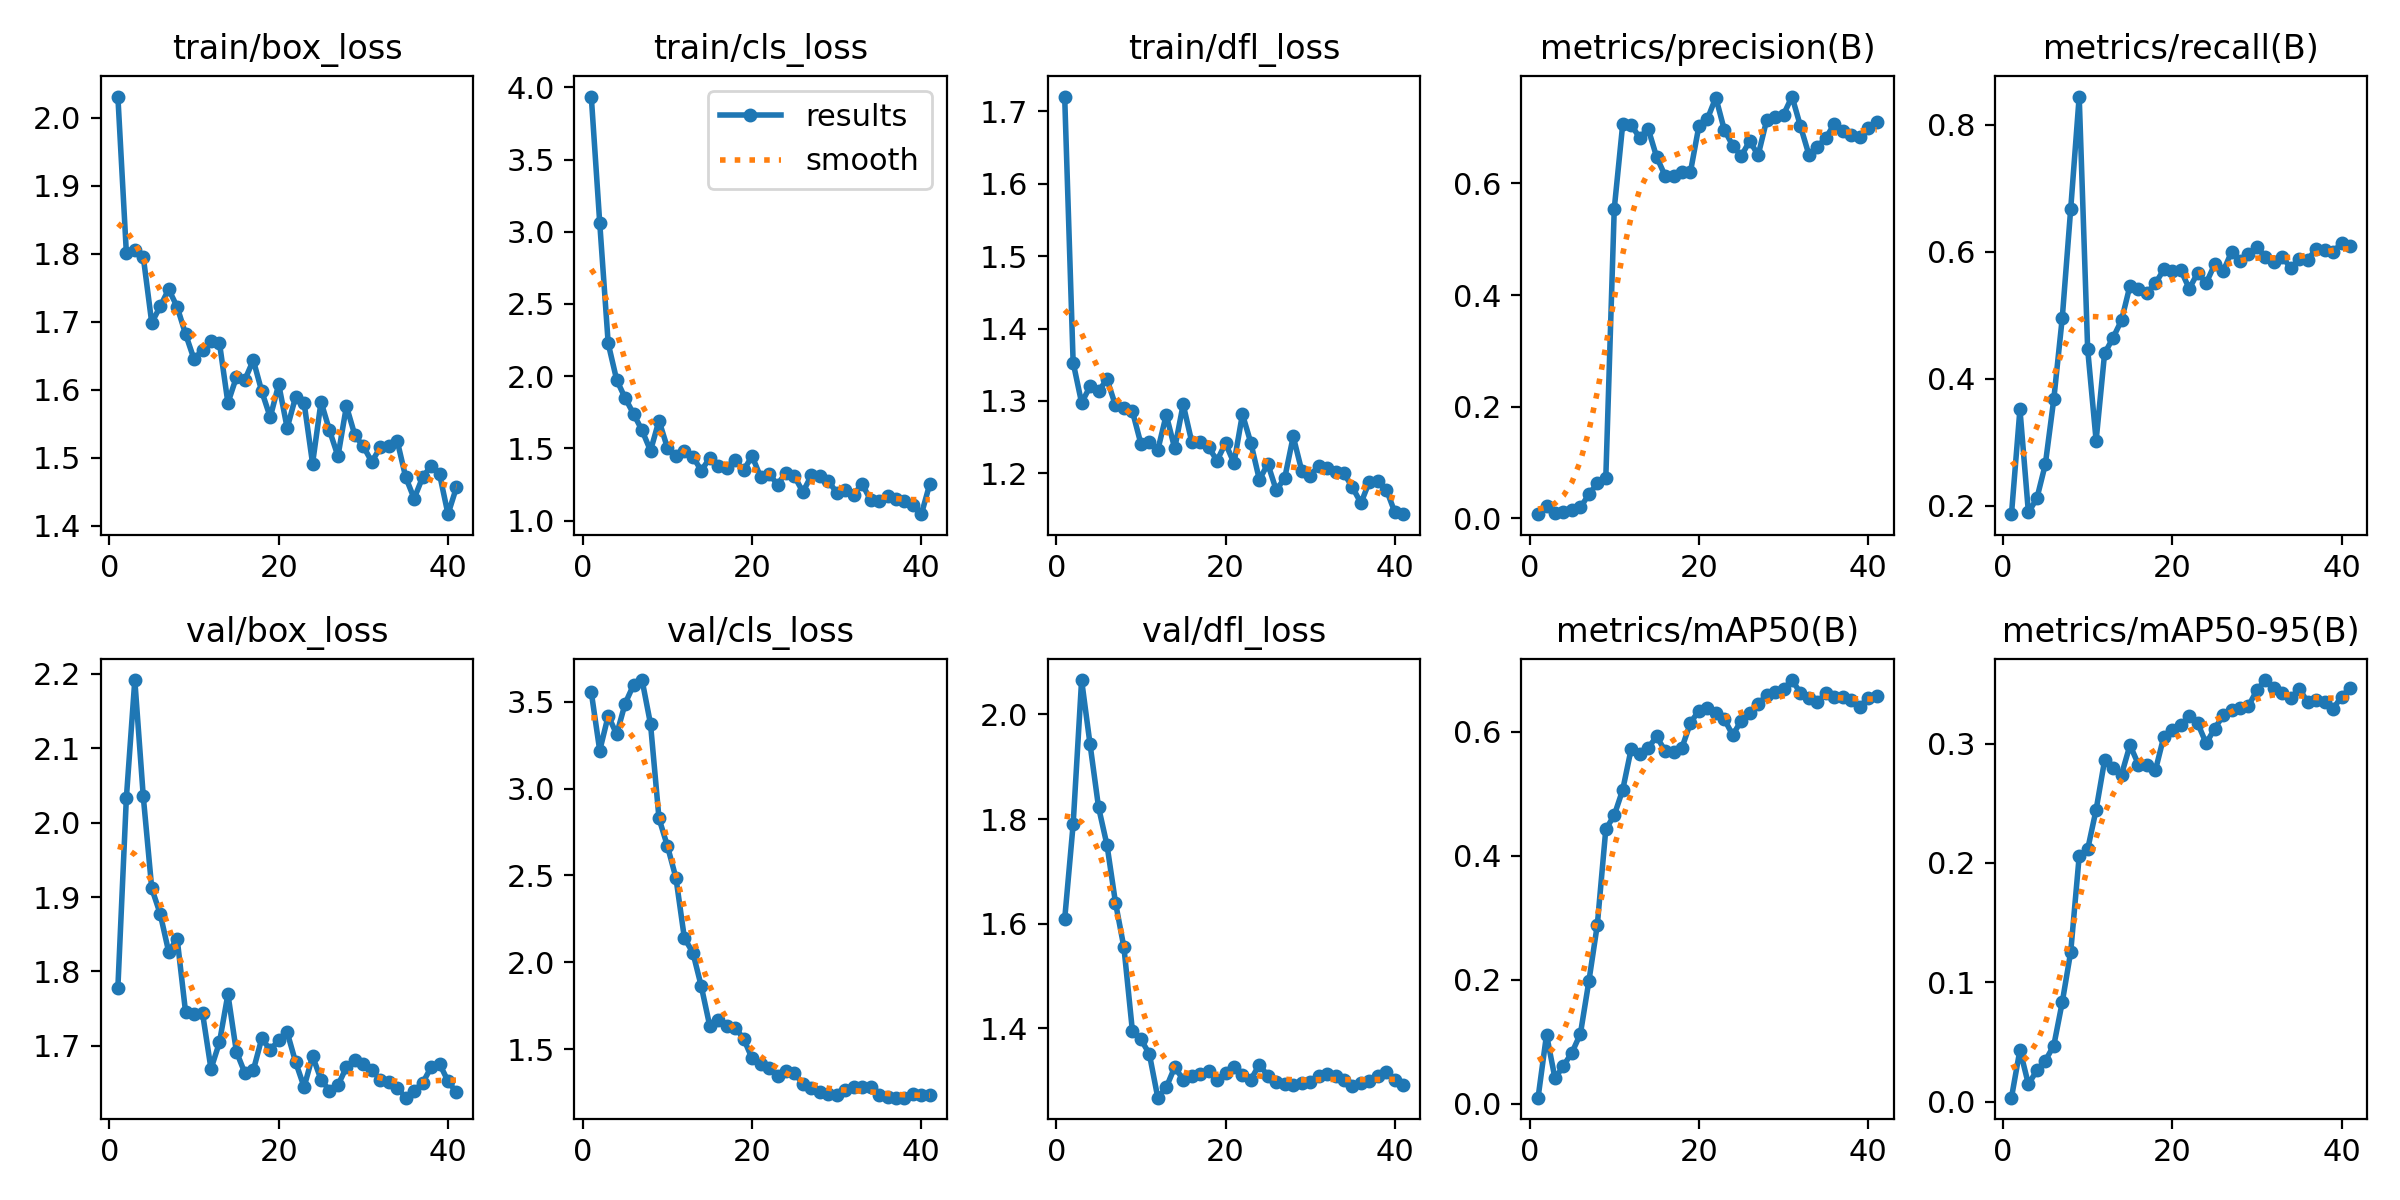

In [36]:
%cd {HOME}
Image(filename=f'{HOME}/{project}/{name_train}/results.png', width=600)

/content


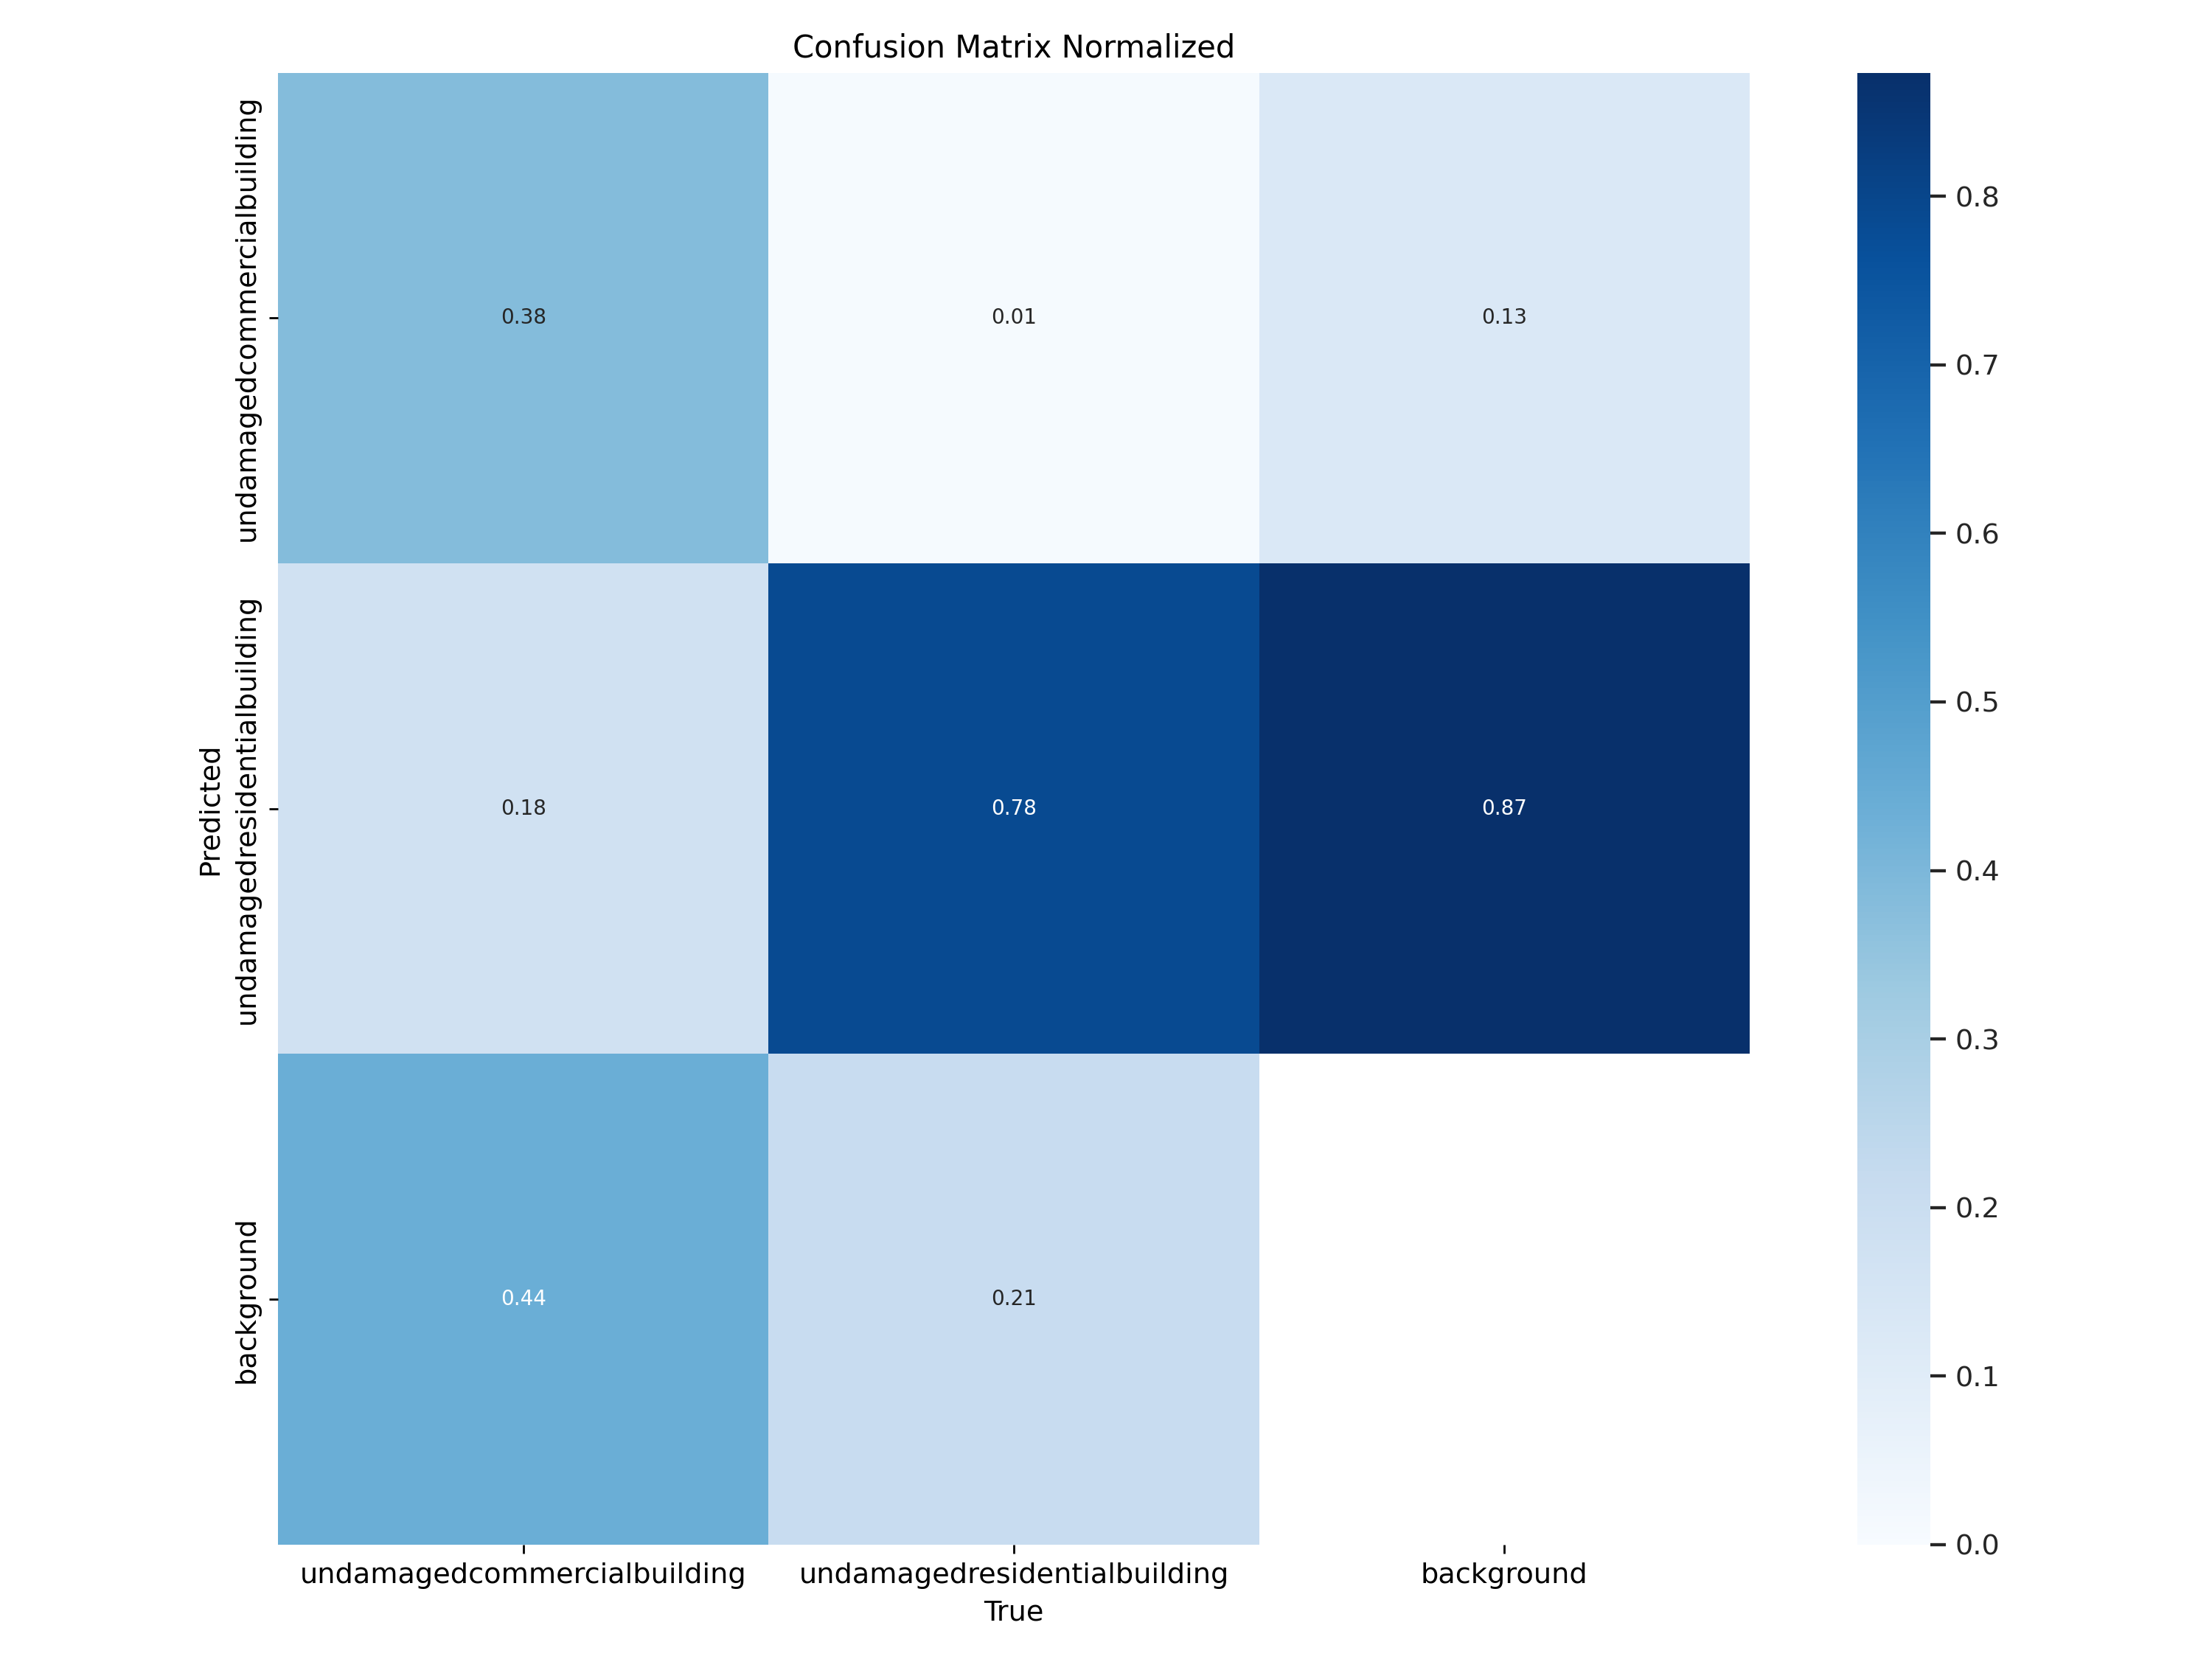

In [37]:
%cd {HOME}
Image(filename=f'{HOME}/{project}/{name_train}/confusion_matrix_normalized.png', width=600)

### Dataset version 5:
Main characteristics: data augmentation on roboflow (3 steps)
batch = 16
lr0 = 5e-4,
momentum = 0.9,
'metrics/mAP50(B)': 0.6598689187019573, 'metrics/mAP50-95(B)': 0.342962345089014

/content


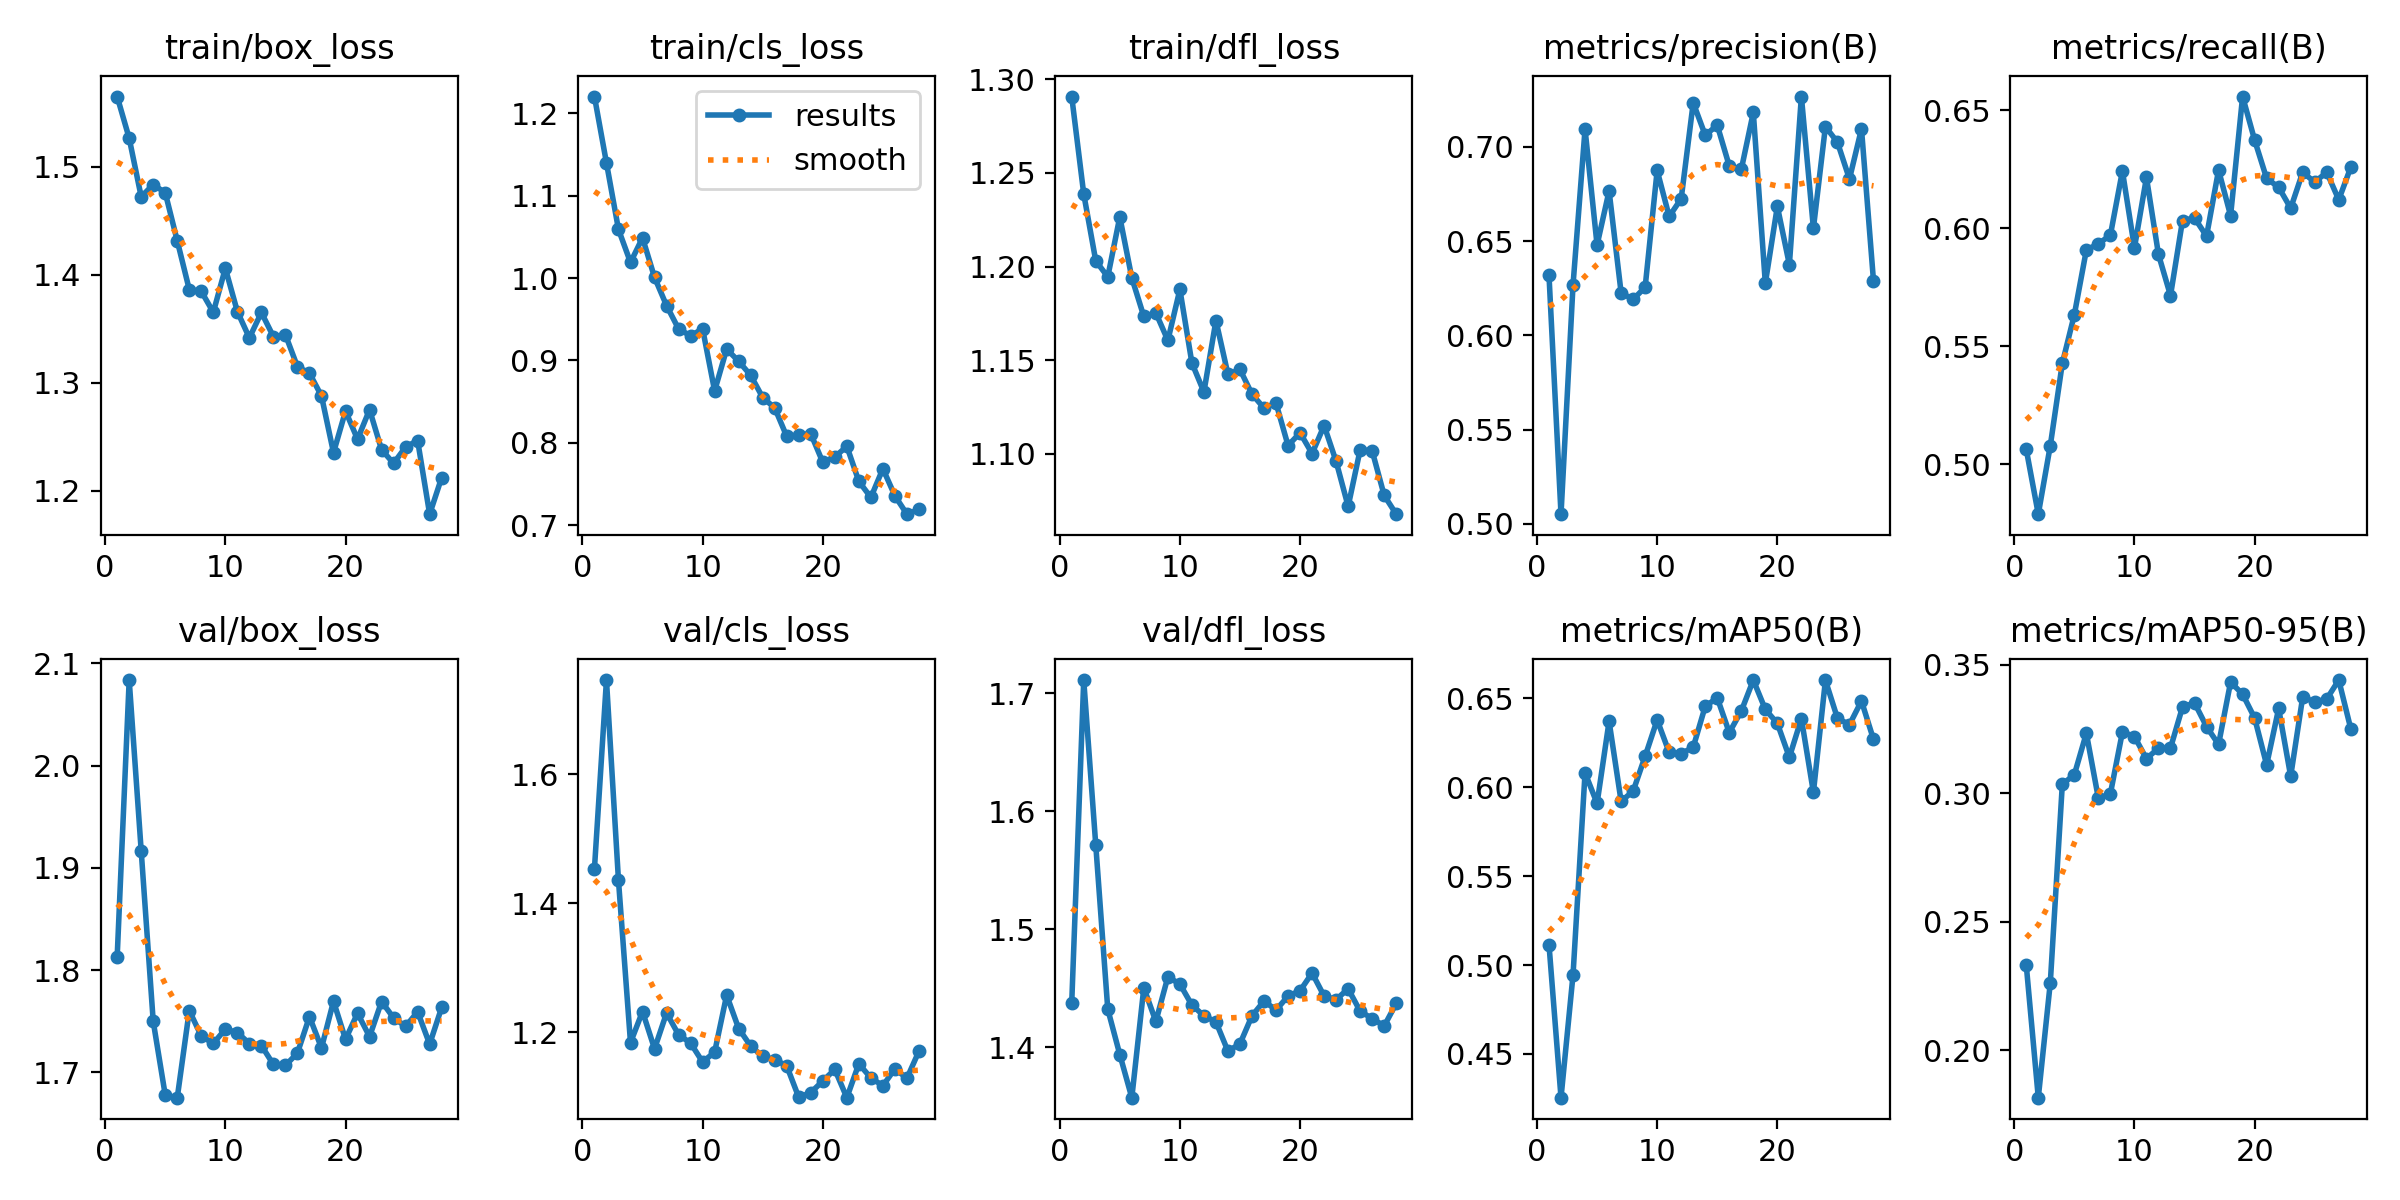

In [23]:
%cd {HOME}
Image(filename=f'{HOME}/{project}/{name_train}3/results.png', width=600)

/content


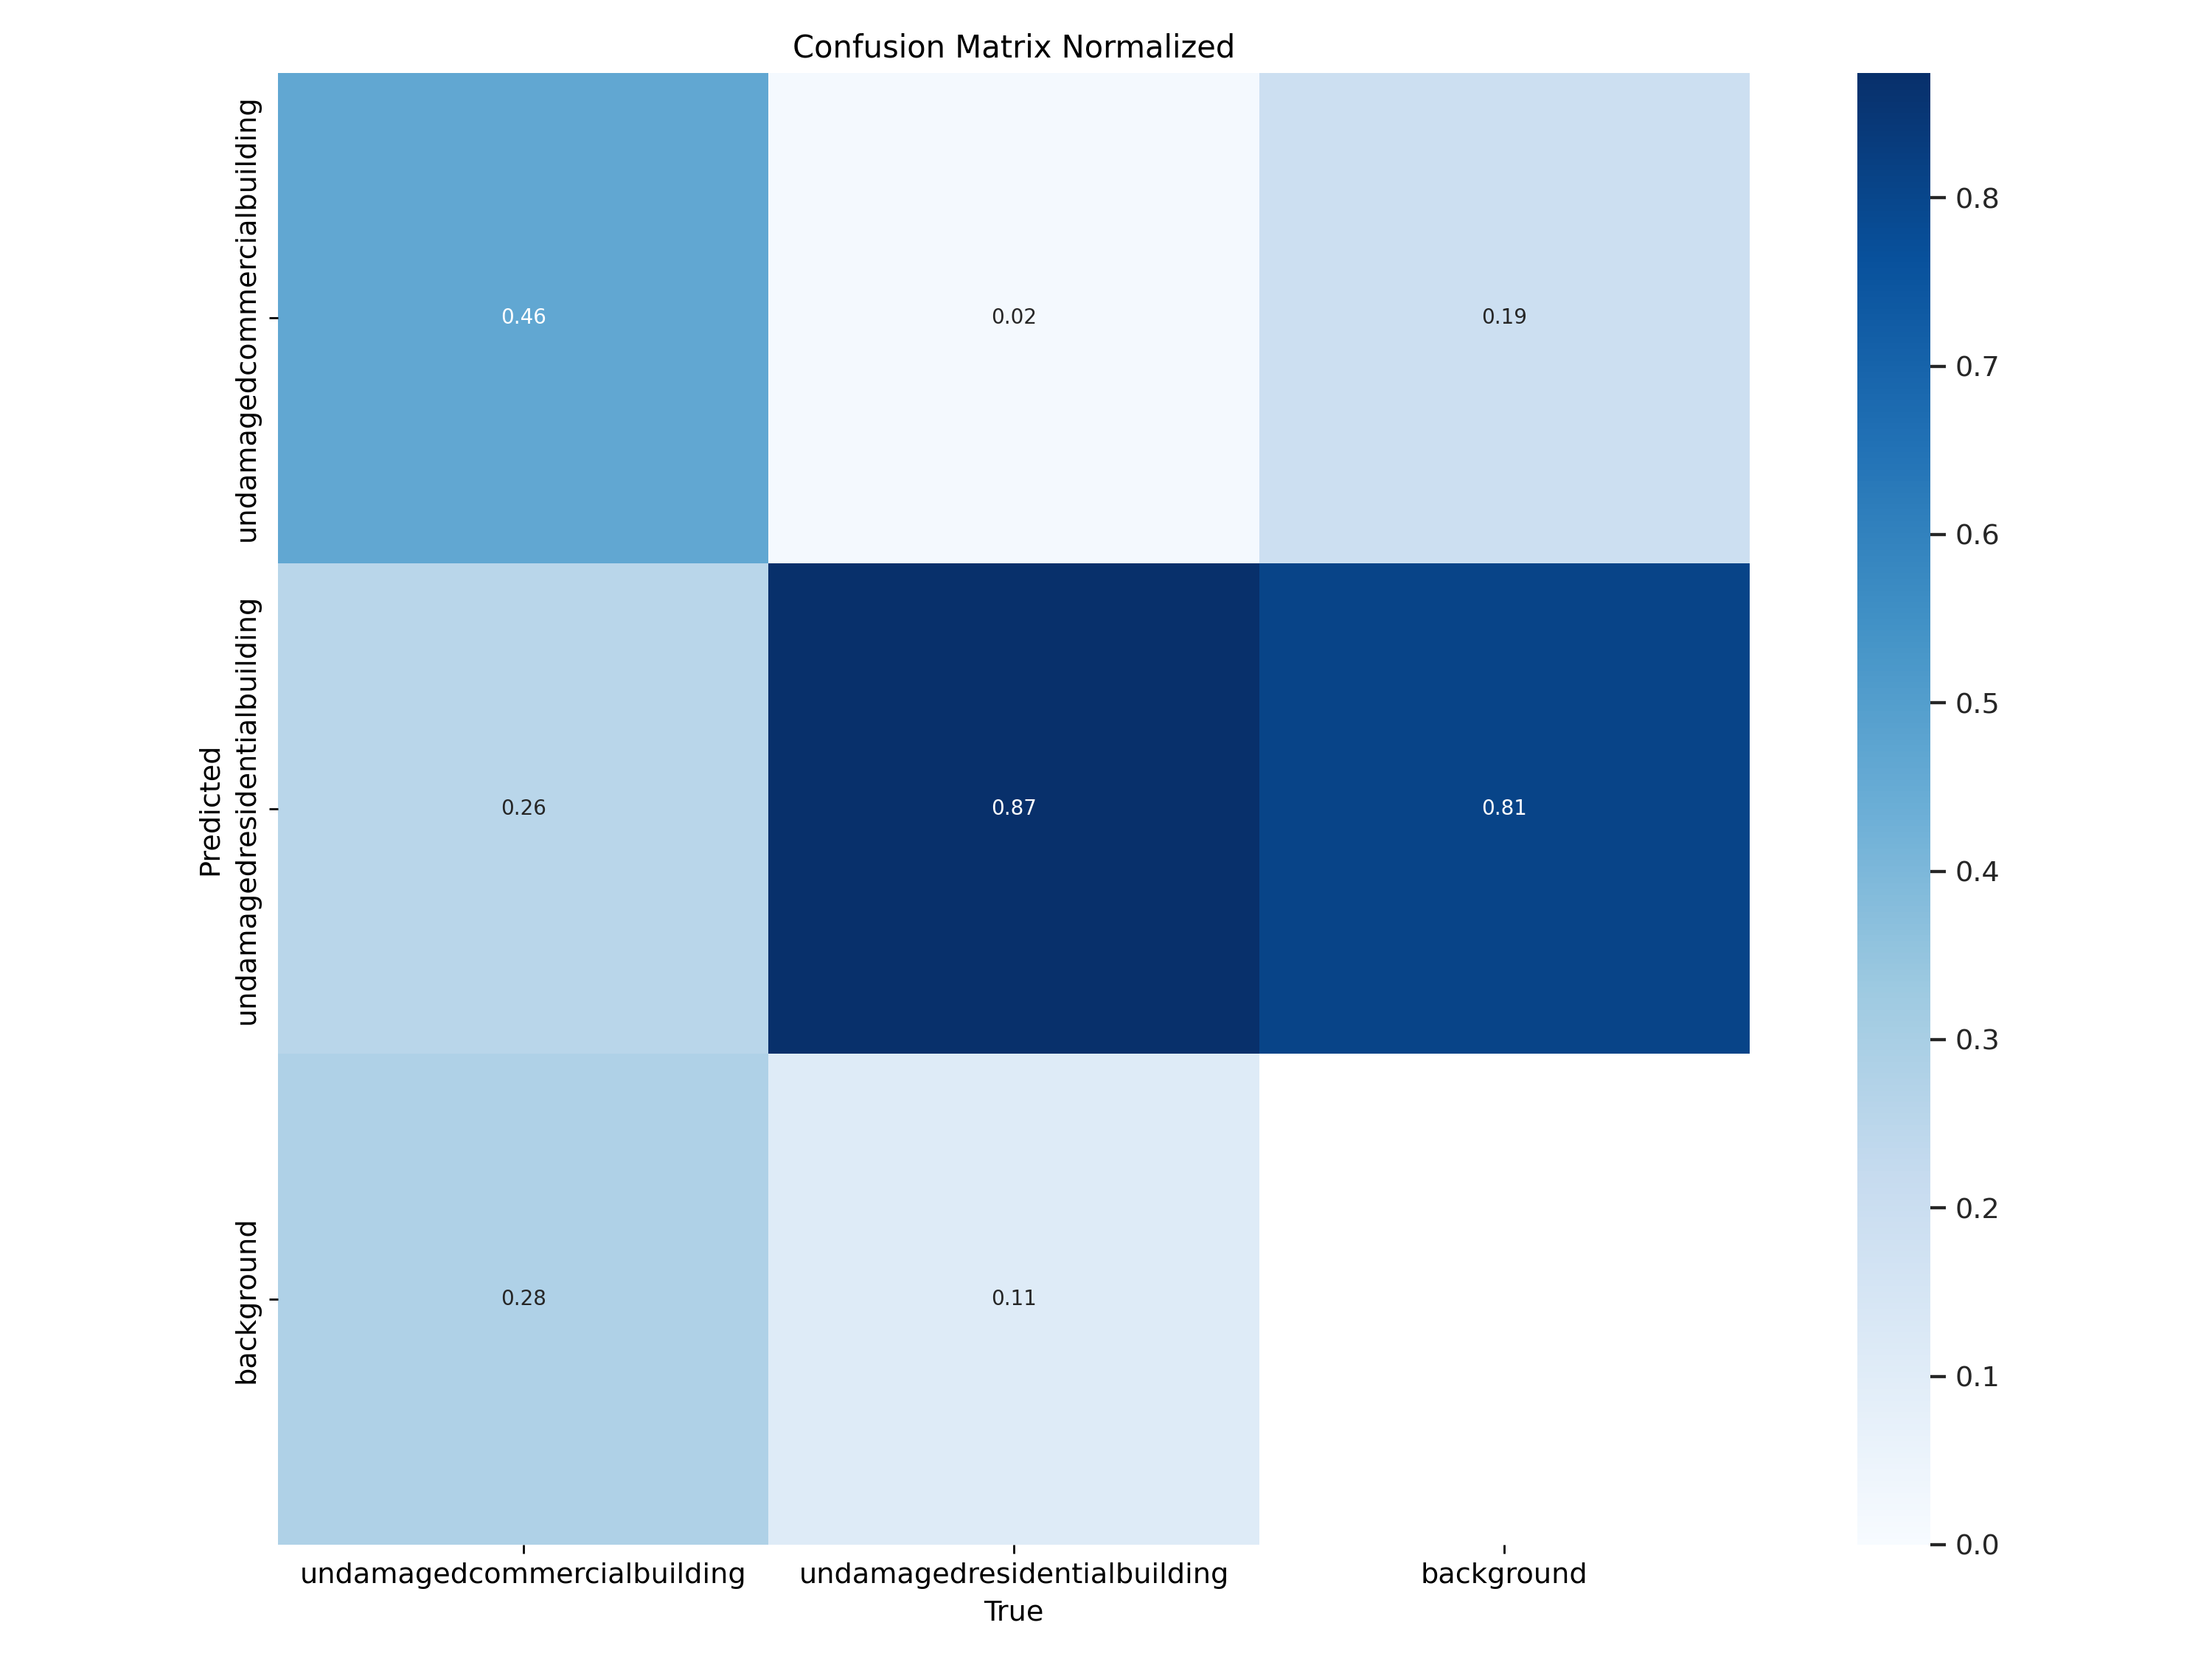

In [24]:
%cd {HOME}
Image(filename=f'{HOME}/{project}/{name_train}3/confusion_matrix_normalized.png', width=600)

## Testing the model performance on Test dataset

Ultralytics YOLOv8 doesn't have a separate mode=test option built-in, as it focuses on training and validation (i.e., mode=train and mode=val).

That being said, if you wish to evaluate your model on a test dataset, you can indeed do so by treating your test data as validation data. After finalizing your model from the validation stage, you can run your model on the test dataset using the mode='val'.

To do this, make sure your test dataset is in the appropriate format expected by YOLOv8. You can simply replace your /val split with your /test data when you're ready to perform testing. This way, you can use the validation mode to evaluate how your model performs on unseen data!

In [ ]:
# Load the model from the best training weights (Note: select path of the "best.pt" file)
path_to_weights_best = f"/{HOME}/{project}/{name_train}/weights/best.pt"
# /content/exploratory_phase/yolo11n_training_dataset_v4/weights/best.pt
model = YOLO(path_to_weights_best)

In [ ]:
# Evaluate model metrics on the "test" dataset split
split_test = 'test'
name_metrics_test = f'metrics_{split_test}' # Directory name for saving results
metrics_test = model.val(data=yaml_file, imgsz=imgsz, batch=16, conf=0.25, iou=0.6, device=device, split=split_test, project=project, name=name_metrics_test)

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /content/Storm-Damage-4/test/labels... 20 images, 16 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<00:00, 3071.63it/s]

val: New cache created: /content/Storm-Damage-4/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]


                   all         20        174      0.645      0.658       0.63      0.335
undamagedcommercialbuilding          3          8      0.429       0.75      0.544       0.28
undamagedresidentialbuilding          4        166      0.862      0.566      0.716       0.39
Speed: 0.3ms preprocess, 20.3ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to exploratory_phase/metrics_test


In [ ]:
# Load the model from the best training weights
split_val = 'val'
name_metrics_val = f'metrics_{split_val}' # Directory name for saving results
# Run the selected model
metrics_val = model.val(data=yaml_file, imgsz=imgsz, batch=16, conf=0.25, iou=0.6, device=device, split=split_val, project=project, name=name_metrics_val)

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/Storm-Damage-4/valid/labels.cache... 66 images, 20 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


                   all         66       1114      0.736      0.488      0.611      0.321
undamagedcommercialbuilding         33        204      0.627      0.338      0.477      0.268
undamagedresidentialbuilding         30        910      0.846      0.638      0.746      0.374
Speed: 0.5ms preprocess, 20.2ms inference, 0.0ms loss, 8.7ms postprocess per image
Results saved to exploratory_phase/metrics_val


In [ ]:
print(f"The model \'{model_version}{model_variant}\' trained on dataset \'{dataset_name}-version{dataset_version}\'")
print(f"Below, comparison of evaluation metrics on dataset splits \'{split_test}\' and \'{split_val}\'")
print("--------------------------------------------------------------------------------")
print(f"Test dataset - mAP of each class: {metrics_test.box.maps}")
print(f"Val dataset - mAP of each class: {metrics_val.box.maps}")
print("--------------------------------------------------------------------------------")
print(f"Test dataset - Mean AP at IoU thresholds from 0.5 to 0.95 for all classes: {metrics_test.box.map}")
print(f"Val dataset - Mean AP at IoU thresholds from 0.5 to 0.95 for all classes: {metrics_val.box.map}")
print("--------------------------------------------------------------------------------")
print(f"Test dataset - Mean AP at IoU threshold of 0.5 for all classes: {metrics_test.box.map50}")
print(f"Val dataset - Mean AP at IoU threshold of 0.5 for all classes: {metrics_val.box.map50}")

The model '11n' trained on dataset 'storm-damage-version4'
Below, comparison of evaluation metrics on dataset splits 'test' and 'val'
--------------------------------------------------------------------------------
Test dataset - mAP of each class: [    0.27978     0.39024]
Val dataset - mAP of each class: [    0.26823     0.37427]
--------------------------------------------------------------------------------
Test dataset - Mean AP at IoU thresholds from 0.5 to 0.95 for all classes: 0.3350125324254318
Val dataset - Mean AP at IoU thresholds from 0.5 to 0.95 for all classes: 0.3212520205089856
--------------------------------------------------------------------------------
Test dataset - Mean AP at IoU threshold of 0.5 for all classes: 0.6298291492460126
Val dataset - Mean AP at IoU threshold of 0.5 for all classes: 0.6114151101434464


## Downloading Results (.zip file)

In [ ]:
from google.colab import files

# Define download parameters and file names
path_dir_to_zip = '/content/exploratory_phase/yolo11n_training_dataset_v4' #@param {type: "string"}
output_filename = 'yolo11n_training_dataset_v4.zip' #@param {type: "string"}
path_zip_file = f'{HOME}/{output_filename}'
delete_zip_file_after_download = "No"  #@param ['Yes', 'No']

os.system("zip -r {} {}".format(output_filename, path_dir_to_zip))
# Download file to local machine
files.download(output_filename)
# Delete the created zip file (optional)
if delete_zip_file_after_download == "Yes":
    os.system("rm -r {}".format(path_zip_file))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Draft Code (not important)

## Loading Training Datasets

Mound google drive which contains the required training dataset

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Check internet speed (optional)

In [ ]:
!curl -s https://raw.githubusercontent.com/sivel/speedtest-cli/master/speedtest.py | python -

Retrieving speedtest.net configuration...
Testing from Google Cloud (34.126.168.143)...
Retrieving speedtest.net server list...
Selecting best server based on ping...
Hosted by PT. Jala Lintas Media (Semarang) [1171.81 km]: 30.175 ms
Testing download speed................................................................................
Download: 263.09 Mbit/s
Testing upload speed......................................................................................................
Upload: 184.19 Mbit/s


Print the current working directory in google collab

In [ ]:
!pwd

/content


Create a new directory for the dataset

In [ ]:
!mkdir data

In [ ]:
!cp -r ../gdrive/MyDrive/Colab\ Notebooks/datasets/hurricanedamagev7.v2i.yolov8.train.valid /content/data

Copy the whole directory with results to a connected google drive

In [ ]:
!scp -r /content/runs /content/gdrive/My Drive/ComputerVision/TrainingResults # adapt to own folder name